In [1]:
from mocpy import MOC
from mocpy.spatial.utils import make_wcs
import numpy as np

%matplotlib inline
import matplotlib.patches as patches
from matplotlib import path

from astropy import units as u

from astropy_healpix import HEALPix
from astropy.coordinates import ICRS, Galactic
from astropy_healpix.core import boundaries_lonlat

from spherical_geometry.polygon import SphericalPolygon
from spherical_geometry import great_circle_arc
from spherical_geometry import vector

In [2]:
def plot_graph(vertices):
    import matplotlib.pyplot as plt
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p = path.Path(vertices)
    patch = patches.PathPatch(p, facecolor='orange', lw=2)
    ax.add_patch(patch)
    print(vertices)
    lon_min = np.min(vertices[:, 0])
    lon_max = np.max(vertices[:, 0])
    lat_min = np.min(vertices[:, 1])
    lat_max = np.max(vertices[:, 1])
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.axis('equal')
    plt.show()

In [3]:
# Define random lon, lat quantities
def generate_rand_polygon(num_points):
    lon_min, lon_max = (-5, 5)
    lat_min, lat_max = (-5, 5)
    lon = (np.random.random(num_points) * (lon_max - lon_min) + lon_min) * u.deg
    lat = (np.random.random(num_points) * (lat_max - lat_min) + lat_min) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

def generate_concave_polygon(num_points):
    delta_ang = (2 * np.pi) / num_points
    radius_max = 10
    
    angles = np.linspace(0, 2 * np.pi, num_points)
    print(angles)
    radius = np.random.random(angles.shape[0]) * radius_max
    
    lon = np.cos(angles) * radius * u.deg
    lat = np.sin(angles) * radius * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

vertices = generate_concave_polygon(20)
print(vertices)
vertices = np.append(vertices, [vertices[0]], axis=0)

[0.         0.33069396 0.66138793 0.99208189 1.32277585 1.65346982
 1.98416378 2.31485774 2.64555171 2.97624567 3.30693964 3.6376336
 3.96832756 4.29902153 4.62971549 4.96040945 5.29110342 5.62179738
 5.95249134 6.28318531]
[[ 5.13353989e+00  0.00000000e+00]
 [ 8.06301519e+00  2.76803661e+00]
 [ 7.81772680e+00  6.08478101e+00]
 [ 5.02315027e+00  7.68850386e+00]
 [ 1.11674236e+00  4.40991583e+00]
 [-4.26645497e-01  5.14884544e+00]
 [-3.12181476e+00  7.11702079e+00]
 [-3.98525070e+00  4.32913629e+00]
 [-3.77598808e+00  2.04346256e+00]
 [-6.32883722e+00  1.05609614e+00]
 [-8.22659137e+00 -1.37277530e+00]
 [-8.16582349e-01 -4.41912268e-01]
 [-1.53666834e+00 -1.66926680e+00]
 [-3.38753274e+00 -7.72279677e+00]
 [-4.28560057e-01 -5.17195074e+00]
 [ 2.20473701e+00 -8.70630957e+00]
 [ 1.21320032e+00 -1.85694133e+00]
 [ 2.30297101e+00 -1.79247429e+00]
 [ 8.68233903e+00 -2.98065075e+00]
 [ 8.37317782e+00 -2.05083708e-15]]


[[ 5.13353989e+00  0.00000000e+00]
 [ 8.06301519e+00  2.76803661e+00]
 [ 7.81772680e+00  6.08478101e+00]
 [ 5.02315027e+00  7.68850386e+00]
 [ 1.11674236e+00  4.40991583e+00]
 [-4.26645497e-01  5.14884544e+00]
 [-3.12181476e+00  7.11702079e+00]
 [-3.98525070e+00  4.32913629e+00]
 [-3.77598808e+00  2.04346256e+00]
 [-6.32883722e+00  1.05609614e+00]
 [-8.22659137e+00 -1.37277530e+00]
 [-8.16582349e-01 -4.41912268e-01]
 [-1.53666834e+00 -1.66926680e+00]
 [-3.38753274e+00 -7.72279677e+00]
 [-4.28560057e-01 -5.17195074e+00]
 [ 2.20473701e+00 -8.70630957e+00]
 [ 1.21320032e+00 -1.85694133e+00]
 [ 2.30297101e+00 -1.79247429e+00]
 [ 8.68233903e+00 -2.98065075e+00]
 [ 8.37317782e+00 -2.05083708e-15]
 [ 5.13353989e+00  0.00000000e+00]]


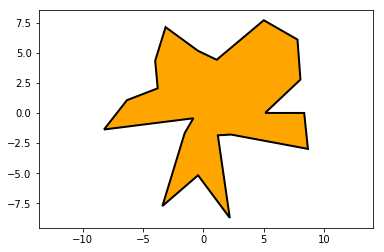

In [4]:
plot_graph(vertices)

from astropy.coordinates import SkyCoord
lon, lat = vertices[:, 0] * u.deg, vertices[:, 1] * u.deg
inside = SkyCoord(ra=-15, dec=-15, unit="deg", frame="icrs")

In [14]:
def poly_crossing_ipix(poly, ipix):
        # ipix and poly are spherical shapes
        poly_points = list(poly.points)[0]
        x_poly, y_poly, z_poly = (poly_points[:, 0], poly_points[:, 1], poly_points[:, 2])

        ipix_points = list(ipix.points)[0]
        x_ipix, y_ipix, z_ipix = (ipix_points[:, 0], ipix_points[:, 1], ipix_points[:, 2])

        A_poly = np.stack((x_poly, y_poly, z_poly)).T
        B_poly = A_poly
        B_poly = np.append(B_poly, [B_poly[1]], axis=0)
        B_poly = B_poly[1:]

        A_poly = A_poly[:-1]
        B_poly = B_poly[:-1]

        for i in range(len(ipix_points) - 1):
            A_ipix = (x_ipix[i], y_ipix[i], z_ipix[i])
            B_ipix = (x_ipix[i+1], y_ipix[i+1], z_ipix[i+1])

            inter = great_circle_arc.intersects(A_poly, B_poly, A_ipix, B_ipix)
            if inter.any():
                return True
        return False

def poly_contains_ipix_vertices(poly, ipix):
    # Get the ipix polygon vertices as a Nx3 numpy array
    # Remove the last vertex as it counts double (closed polygon)
    ipix_vertices = list(ipix.points)[0][:-1, :]

    for ipix_vertex in ipix_vertices:
        if not poly.contains_point(ipix_vertex):
            return False

    return True


def polygon_contains_ipix(poly, ipix):
    return poly_contains_ipix_vertices(poly, ipix) and (not poly_contains_ipix_vertices(ipix, poly)) and (not poly_crossing_ipix(poly, ipix))


def build_ipix_cells(poly, d, ipixel, end_depth, ipix_moc_d):
    #hp = HEALPix(nside=(1 << d), order='nested', frame=ICRS())

    lon, lat = boundaries_lonlat(ipixel, step=1, nside = (1 << d), order="nested")
    lon = lon.to(u.rad).value
    lat = lat.to(u.rad).value
    ipix_vertices = np.vstack((lon, lat)).T
    ipix_poly = SphericalPolygon.from_radec(lon=ipix_vertices[:, 0], lat=ipix_vertices[:, 1], degrees=False)

    inter_poly = poly.intersects_poly(ipix_poly)

    if not inter_poly:
        return

    if d == end_depth:
        ipix_moc_d[str(d)].append(ipixel)
    else:
        if polygon_contains_ipix(poly, ipix_poly):
            ipix_moc_d[str(d)].append(ipixel)
        else:
            child_ipix = ipixel << 2

            build_ipix_cells(poly, d + 1, child_ipix, end_depth, ipix_moc_d)
            build_ipix_cells(poly, d + 1, child_ipix + 1, end_depth, ipix_moc_d)
            build_ipix_cells(poly, d + 1, child_ipix + 2, end_depth, ipix_moc_d)
            build_ipix_cells(poly, d + 1, child_ipix + 3, end_depth, ipix_moc_d)

def closes_numpy_2d_array(x):
    tmp = np.zeros((x.shape[0], x.shape[1] + 1))
    tmp[:, :-1] = x
    tmp[:, -1] = x[:, 0]
    return tmp
    
"""
from threading import Thread
class RecursiveWorkerThread(Thread):
    def __init__(self, polygon, start_depth, ipix, end_depth, ipix_dd):
        Thread.__init__(self)
        self.polygon = polygon
        self.start_depth = start_depth
        self.ipix = ipix
        self.end_depth = end_depth
        
        #import copy
        self.ipix_dd = ipix_dd
        
        self.moc = None

    def run(self):
        build_ipix_cells(self.polygon, self.start_depth, self.ipix, self.end_depth, self.ipix_dd)
        #self.moc = MOC.from_json(self.ipix_dd)
"""
from threading import Thread
class SequentialWorkerThread(Thread):
    def __init__(self, polygon, shapes, ipixels_l, ipix_in_polygon_l, ipix_inter_polygon_l, depth, end_depth, begin, end):
        Thread.__init__(self)
        self.polygon = polygon
        self.shapes = shapes
        self.ipixels_l = ipixels_l
        self.ipix_in_polygon_l = ipix_in_polygon_l
        self.ipix_inter_polygon_l = ipix_inter_polygon_l
        
        self.depth = depth
        self.end_depth = end_depth
        
        self.begin = begin
        self.end = end

    def run(self):
        for i in range(self.begin, self.end):
            # Spherical polygon asks for a closed list of vertices. We add its first vertex to the end.
            shape = self.shapes[i]

            ipix_shape = SphericalPolygon.from_radec(lon=shape[:, 0], lat=shape[:, 1], degrees=False)
            ipix = self.ipixels_l[i]
            if self.polygon.intersects_poly(ipix_shape):
                # If we are at the max depth then we direcly add to the MOC the intersecting ipixels
                if self.depth == self.end_depth:
                    self.ipix_in_polygon_l.append(ipix)
                else:
                    # Check whether polygon contains ipix or not
                    if polygon_contains_ipix(self.polygon, ipix_shape):
                        self.ipix_in_polygon_l.append(ipix)
                    else:
                        # The ipix is just intersecting without being contained in the polygon
                        # We split it in its 4 children
                        child_ipix = ipix << 2
                        self.ipix_inter_polygon_l.extend([child_ipix,
                                                          child_ipix + 1,
                                                          child_ipix + 2,
                                                          child_ipix + 3])        

def from_polygon(lon, lat, inside=None, max_depth=10):
    """
    Create a MOC from a polygon

    Parameters
    ----------
    lon : `~astropy.units.Quantity`
        The longitudes defining the polygon. Can describe convex and concave polygons but no self-intersecting ones.
    lat : `~astropy.units.Quantity`
        The latitudes defining the polygon. Can describe convex and concave polygons but no self-intersecting ones.
    inside : `~astropy.coordinates.SkyCoord`, optional
        A point that will be inside the MOC is needed as it is not possible to determine the inside area of a polygon 
        on the unit sphere (there is no infinite area that can be considered as the outside.
        On the sphere, a polygon delimits two finite areas.).
        Possible improvement: take the inside area as the one covering the less of the sphere.

        If inside=None (default behavior), the mean of all the vertices is taken as lying inside the polygon. That approach may not work for 
        concave polygons.
    max_depth: int, optional
        The resolution of the MOC. Set to 10 by default.

    Returns
    -------
    result : `~mocpy.moc.MOC`
        The resulting MOC
    """
    def getStartingDepth(poly):
        def compute_angular_distance(n1, n2, normalize=True):
            if normalize:
                vector.normalize_vector(n1, output=n1)
                vector.normalize_vector(n2, output=n2)
            
            return np.arctan(np.linalg.norm(np.cross(n1, n2))/np.dot(n1, n2))
        
        def max_distance_center_to_vertex(depth):
            nside = (1 << depth)

            lat1 = np.arcsin(2/3)
            lat2 = np.arcsin(1 - ((1 - 1/nside)**2 / 3))
            lon1 = np.pi/4 * 1 / nside
            lon2 = 0
            
            n1 = np.asarray(vector.lonlat_to_vector(lon=lon1, lat=lat1, degrees=False))
            n2 = np.asarray(vector.lonlat_to_vector(lon=lon2, lat=lat2, degrees=False))
            
            return compute_angular_distance(n1, n2) # in rad
            
        # Get the polygon vertices as a Nx3 numpy array
        # Remove the last vertex as it counts double (closed polygon)
        p_vertices = np.asarray(list(poly.points))[0][:-1, :]
        # Get the center formed by the vertices
        center = p_vertices.mean(axis=0)
        
        # Normalize it so that it lies on the unit sphere
        vector.normalize_vector(center, output=center)
        center = np.asarray(center)
        # Compute the maximum angular distance between the polygon vertices 
        # and its center. This refers to the Vector version of the
        # Great-circle distance computation.
        #
        # See https://en.wikipedia.org/wiki/Great-circle_distance
        max_d = -1;
        
        # Check if the polygon covers more than an hemisphere
        covers_more_than_one_hemisphere = (poly.area() > 2 * np.pi)
        print("AREA:", poly.area())
        if covers_more_than_one_hemisphere:
            print('covers more than one hemisphere')

        for vertex in p_vertices:
            d = compute_angular_distance(center, vertex)
            if covers_more_than_one_hemisphere:
                d = np.pi - d

            if d > max_d:
                max_d = d
        
        # Return the min depth so that max_d > max_center_to_vertex_ipix(depth)
        depth = 0
        while max_distance_center_to_vertex(depth) >= max_d:
            print(depth)
            depth = depth + 1
        
        # Get the ipixels from astropy_healpix covering the cone of (center, radius) = (center, max_d)
        lon_center, lat_center = vector.vector_to_lonlat(x=center[0], y=center[1], z=center[2], degrees=False)
        hp = HEALPix(nside=(1 << depth), order='nested', frame=ICRS())
        starting_iter_ipix = hp.cone_search_lonlat(lon=lon_center * u.rad, lat=lat_center * u.rad, radius=max_d * u.rad)
        
        return depth, starting_iter_ipix

    ipix_d = {}

    ra = lon.to(u.rad).value
    dec = lat.to(u.rad).value
    # Check if the vertices form a closed polygon
    if ra[0] != ra[-1] or dec[0] != dec[-1]:
        # If not, append the first vertex to ``vertices``
        ra = np.append(ra, ra[0])
        dec = np.append(dec, dec[0])
        vertices = SkyCoord(ra=ra, dec=dec, unit="rad", frame="icrs")
        print('not closed polygon')

    if inside:
        # Convert it to (x, y, z) cartesian coordinates on the sphere
        inside = (inside.icrs.ra.rad, inside.icrs.dec.rad)

    polygon = SphericalPolygon.from_lonlat(lon=ra, lat=dec, center=inside, degrees=False)

    start_depth, ipixels = getStartingDepth(polygon)
    end_depth = max_depth
    print("start depth: ", start_depth)
    print("start ipix at starting depth: ", ipixels)
    print("num ipix to start with: ", len(ipixels))
    
    # When the start depth returned is > to the depth requested
    # For that specific case, we only do one iteration at start_depth
    # Thus the MOC will contain the partially intersecting cells with the 
    # contained ones at start_depth
    
    # And we degrade the MOC to the max_depth
    degrade_to_max_depth = False
    if start_depth > end_depth:
        end_depth = start_depth
        degrade_to_max_depth = True

    ipix_d = {str(order): [] for order in range(start_depth, end_depth + 1)}

    ## Iterative version of the algorithm: seems a bit faster than the recursive one
    """
    for depth in range(start_depth, end_depth + 1):
        print(depth)
        hp = HEALPix(nside=(1 << depth), order='nested', frame=ICRS())
        
        lon, lat = hp.boundaries_lonlat(ipixels, step=1)
        lon = lon.to(u.rad).value
        lat = lat.to(u.rad).value
        
        lon_tmp = np.zeros((lon.shape[0], lon.shape[1] + 1))
        lon_tmp[:, :-1] = lon
        lon_tmp[:, -1] = lon[:, 0]
        lon = lon_tmp
        
        lat_tmp = np.zeros((lat.shape[0], lat.shape[1] + 1))
        lat_tmp[:, :-1] = lat
        lat_tmp[:, -1] = lat[:, 0]
        lat = lat_tmp
       
        num_ipix_inter_poly = ipixels.shape[0]
    
        shapes = np.vstack((lon.ravel(), lat.ravel())).T.reshape(num_ipix_inter_poly, 5, -1)

        ipix_in_polygon_l = []
        ipix_inter_polygon_l = []
        ipixels_l = list(ipixels)
        
        chunk_size = 1000
        threads = []
        print('num threads: ', int(num_ipix_inter_poly / chunk_size) + 1)
        for i in range(0, num_ipix_inter_poly, chunk_size):
            begin = i
            end = min(i + chunk_size, num_ipix_inter_poly)
            
            th = SequentialWorkerThread(polygon, shapes, ipixels_l, ipix_in_polygon_l, ipix_inter_polygon_l, depth, end_depth, begin, end)
            threads.append(th)
            th.start()
            
        for th in threads:
            th.join()
        
        ipix_d.update({str(depth): ipix_in_polygon_l})
        ipixels = np.asarray(ipix_inter_polygon_l)
    """
    
    for depth in range(start_depth, end_depth + 1):
        print(depth)
        # Define a HEALPix at the current depth
        hp = HEALPix(nside=(1 << depth), order='nested', frame=ICRS())
        
        # Get the lon and lat of the corners of the pixels
        # intersecting the polygon
        lon, lat = hp.boundaries_lonlat(ipixels, step=1)
        lon = lon.to(u.rad).value
        lat = lat.to(u.rad).value
        
        # closes the lon and lat array so that their first and last value matches
        lon = closes_numpy_2d_array(lon)
        lat = closes_numpy_2d_array(lat)
        
        num_ipix_inter_poly = ipixels.shape[0]
        
        # Define a 3d numpy array containing the corners coordinates of the intersecting pixels
        # The first dim is the num of ipixels
        # The second is the number of coordinates (5 as it defines the closed polygon of a HEALPix cell)
        # The last is of size 2 (lon and lat)
        shapes = np.vstack((lon.ravel(), lat.ravel())).T.reshape(num_ipix_inter_poly, 5, -1)

        ipix_in_polygon_l = []
        ipix_inter_polygon_l = []
        
        for i in range(num_ipix_inter_poly):
            shape = shapes[i]
            # Definition of a SphericalPolygon from the border coordinates of a HEALPix cell
            ipix_shape = SphericalPolygon.from_radec(lon=shape[:, 0], lat=shape[:, 1], degrees=False)
            ipix = ipixels[i]

            if polygon.intersects_poly(ipix_shape):
                # If we are at the max depth then we direcly add to the MOC the intersecting ipixels
                if depth == end_depth:
                    ipix_in_polygon_l.append(ipix)
                else:
                    # Check whether polygon contains ipix or not
                    if polygon_contains_ipix(polygon, ipix_shape):
                        ipix_in_polygon_l.append(ipix)
                    else:
                        # The ipix is just intersecting without being contained in the polygon
                        # We split it in its 4 children
                        child_ipix = ipix << 2
                        ipix_inter_polygon_l.extend([child_ipix,
                                                     child_ipix + 1,
                                                     child_ipix + 2,
                                                     child_ipix + 3])

        ipix_d.update({str(depth): ipix_in_polygon_l})
        ipixels = np.asarray(ipix_inter_polygon_l)
    
    # Create the moc from the python dictionary
    moc = MOC.from_json(ipix_d)
    """
    ## Parallel recursive algo
    ipix_dd = {str(order): [] for order in range(start_depth, end_depth + 1)}
    print("begin dict:", ipix_dd)
    threads = []
    for i in range(len(ipix_inter_polygon)):
        ipix = ipix_inter_polygon[i]
        th = WorkerThread(polygon, start_depth, ipix, end_depth, ipix_dd)
        threads.append(th)
        th.start()
        
    for th in threads:
        th.join()
    
    moc = MOC.from_json(threads[0].ipix_dd)
    """
    """
    ipix_dd = {str(order): [] for order in range(start_depth, end_depth + 1)}
    print("begin dict:", ipix_dd)
    ## Sequential recursive algo
    for ipix in ipix_inter_polygon:
        build_ipix_cells(polygon, start_depth, ipix, end_depth, ipix_dd)
    
    moc = MOC.from_json(ipix_dd)
    """
    #print("end dict:", ipix_dd)
    # We degrade it to the user-requested order 
    if degrade_to_max_depth:
        moc = moc.degrade_to_order(max_depth)
        
    return moc
    

In [15]:
def plot(moc, lon, lat):
    import matplotlib.pyplot as plt
    from astropy.wcs.utils import skycoord_to_pixel
    # MOCPy offers a way to easily create an `astropy.wcs.WCS` object.
    # This define an ICRS aitoff projection.
    wcs = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["RA---AIT", "DEC--AIT"])
    
    fig = plt.figure(figsize=(10, 10))
    #ax = fig.add_axes([0.5, 0.1, 0.8, 0.8], projection=wcs)
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    # Create an mpl axe
    #fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={"projection": wcs})

    # Calls to `mocpy.MOC.fill` for each of the three MOCs with various mpl styling keywords
    # to differentiate them from each other.
    moc.fill(ax=ax, wcs=wcs, edgecolor='g', facecolor='g', linewidth=1.0, fill=True, alpha=0.5)
    
    #plt.axis('equal')
    plt.xlabel('ra')
    plt.ylabel('dec')
    
    lon_min = np.min(lon)
    lon_max = np.max(lon)
    lat_min = np.min(lat)
    lat_max = np.max(lat)

    c1 = SkyCoord(ra=lon_min, dec=lat_min, frame="icrs")
    c2 = SkyCoord(ra=lon_max, dec=lat_max, frame="icrs")

    x1, y1 = skycoord_to_pixel(c1, wcs)
    x2, y2 = skycoord_to_pixel(c2, wcs)
    
    if x1 > x2:
        tmp = x1
        x1 = x2
        x2 = tmp

    if y1 > y2:
        tmp = y1
        y1 = y2
        y2 = tmp
    
    plt.grid(color='black', ls='solid')
    off_x = (x2 - x1) * 0.05
    off_y = (y2 - y1) * 0.05
    ax.set_xlim([x1 - off_x, x2 + off_x])
    ax.set_ylim([y1 - off_y, y2 + off_y])
    #ax.axis('equal')
    
    plt.title('from polygon')
    #plt.grid(color="black", linestyle="dotted")
    plt.show()
    plt.close()

not closed polygon
AREA: 3.2244074077425466e-10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
start depth:  17
start ipix at starting depth:  [89921647231 89921647402 89921647488 89921647317 89921647316 89921647230
 89921647228 89921647229 89921647400 89921647403 89921647223 89921647222
 89921647225 89921647227 89921647489 89921647490 89921647319]
num ipix to start with:  17
17
18
19
20
CPU times: user 116 ms, sys: 4.22 ms, total: 120 ms
Wall time: 117 ms


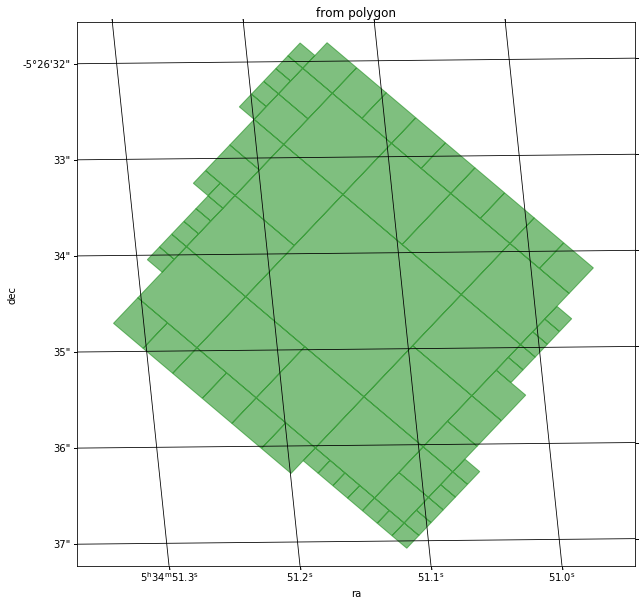

In [18]:
lon = [83.71315909, 83.71378887, 83.71297292, 83.71233919] * u.deg
lat = [-5.44217436,-5.44298864, -5.44361751, -5.4428033] * u.deg
#print(lon, lat)
inside = SkyCoord(-15, -15, unit="deg", frame="icrs")
%time moc = from_polygon(lon=lon, lat=lat, max_depth=20, inside=None)
#print('order moc:', moc.max_order)
plot(moc, lon, lat)


In [19]:
moc.write("daniel.fits", format="fits")